In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import time, datetime
pd.set_option('display.max_rows', 101)
!date

Mon Feb 24 13:50:50 PST 2020


# Aggregate and plot outputs of Minimal minority-majority sim

launch code at /ihme/code/beatrixh/microsim_2020/census_2020/launch_majority_minority_jobs.py \
sim code at /ihme/code/beatrixh/microsim_2020/census_2020/launch_majority_minority_jobs.py

In [51]:
def summarize_dir(path):
    """
    Parameter: input dir containing csvs
    ---------
    Output: 1-column df containing the row means of the concatenated csvs
    """
    files = os.listdir(path)
    output = pd.DataFrame(np.zeros([11,1]))
    for file in files:
        df = pd.read_csv(path + '/' + file, index_col=False)
        df = df.iloc[:,1:]
        output = pd.concat([output,df], axis=1, ignore_index=True)
    return output.mean(axis=1)

In [52]:
weighted_path = '/ihme/scratch/users/beatrixh/2020-02-24/wei/'
std_path = '/ihme/scratch/users/beatrixh/2020-02-24/non/'

weighted_dirs = [weighted_path + i for i in os.listdir(weighted_path)]
std_dirs = [std_path + i for i in os.listdir(std_path)]

weighted_dt = pd.DataFrame()
for path in weighted_dirs:
    new = summarize_dir(path)
    weighted_dt = pd.concat([weighted_dt, new], axis = 1, ignore_index=True)
# print(weighted_dt.T)

std_dt = pd.DataFrame()
for path in std_dirs:
    new = summarize_dir(path)
    std_dt = pd.concat([std_dt, new], axis = 1, ignore_index=True)

In [53]:
names = ['precise','dp','non_neg','pct_change',
        'number_counties','alpha','beta','total_pop',
        'prop_minority','segregation_factor','seed']
names_dict = {i : names[i] for i in range(0,len(names))}
data_weighted = weighted_dt.T.rename(columns=names_dict)
# data_weighted.sort_values(by='total_pop')

In [54]:
names = ['precise','dp','non_neg','pct_change',
        'number_counties','alpha','beta','total_pop',
        'prop_minority','segregation_factor','seed']
names_dict = {i : names[i] for i in range(0,len(names))}
data_std = std_dt.T.rename(columns=names_dict)
# data_std.sort_values(by='total_pop')

## standard: $\sum_{i\in\text{counties}} (\text{dp_counts(i)}-\text{non-neg_counts(i)})^2$

## weighted: $\sum_{i\in\text{counties}} \text{dp_counts(i)}^2\times (\text{dp_counts(i)}-\text{non-neg_counts(i)})^2$

## grouped: $\sum_{i\in\text{counties}}(\text{dp_counts(i)}-\text{non-neg_counts(i)})^2 + \
((\sum_{j\in L} \text{dp_counts(j)}))-(\sum_{j\in L} \text{non-neg_counts(j)}))$
where $L=\{\text{counties with dp counts larger than k}\}$ and $k=$ $98^{th}$ quantile of the dp counts

In [55]:
compare_weighted_to_std = data_std.merge(data_weighted, how = 'inner',
                                         on = ['precise','dp','total_pop','seed',
                                               'alpha','beta','number_counties','prop_minority'],
                                         suffixes=('_std','_weighted'))
print(data_std.shape)
print(data_weighted.shape)
print(compare_weighted_to_std.shape)
compare_weighted_to_std[['precise','dp','non_neg_std','non_neg_weighted','total_pop',
                         'pct_change_std','pct_change_weighted']].sort_values('total_pop')

(10, 11)
(9, 11)
(9, 14)


,precise,dp,non_neg_std,non_neg_weighted,total_pop,pct_change_std,pct_change_weighted
3,37.235764,37.987013,2.460612,2.370797,2.997003e+03,0.931037,0.932939
7,191.737263,192.488511,14.622474,14.188028,9.477356e+03,0.921817,0.924062
2,722.678322,724.028971,81.132914,83.290169,2.997003e+04,0.887322,0.884349
0,2438.414585,2449.876124,936.100693,1123.468586,9.477356e+04,0.618800,0.542943
5,7890.475524,7874.085914,5721.404956,6498.866427,2.997003e+05,0.276768,0.178137
4,25151.210789,25142.654346,22687.311832,24030.444526,9.477356e+05,0.098797,0.045126
6,79748.700300,79730.367632,77212.359833,78899.852392,2.997003e+06,0.032099,0.010775
8,252406.841159,252411.167832,249937.005902,251792.126827,9.477356e+06,0.009884,0.002469
1,798436.925075,798446.857143,796066.614331,797972.402752,2.997003e+07,0.003001,0.000593


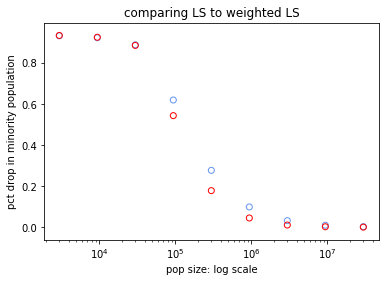

In [47]:
x = compare_weighted_to_std['total_pop']
y_1 = compare_weighted_to_std['pct_change_std']
y_2 = compare_weighted_to_std['pct_change_weighted']

fig = plt.figure() 

ax = fig.add_subplot(111)
ax.scatter(x, y_1, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, y_2, facecolors='none', edgecolors = 'red')

plt.xscale('log')
plt.xlabel('pop size: log scale')
plt.ylabel('pct drop in minority population')
plt.title("comparing LS to weighted LS")

plt.show()

## adding in nonneg shifted weighted

In [89]:
nn_opt_shifted = '/ihme/scratch/users/beatrixh/2020-02-24/nn_opt_shifted_weighte'

shifted_weighted_dt = pd.DataFrame()
for path in weighted_dirs:
    new = summarize_dir(path)
    shifted_weighted_dt = pd.concat([shifted_weighted_dt, new], axis = 1, ignore_index=True)
print(shifted_weighted_dt.T)

              0              1              2         3           4       5   \
0    2438.414585    2449.876124    1123.468586  0.542943  9990.00999  0.1998   
1  798436.925075  798446.857143  797972.402752  0.000593  9990.00999  0.1998   
2     722.678322     724.028971      83.290169  0.884349  9990.00999  0.1998   
3      37.235764      37.987013       2.370797  0.932939  9990.00999  0.1998   
4   25151.210789   25142.654346   24030.444526  0.045126  9990.00999  0.1998   
5    7890.475524    7874.085914    6498.866427  0.178137  9990.00999  0.1998   
6   79748.700300   79730.367632   78899.852392  0.010775  9990.00999  0.1998   
7     191.737263     192.488511      14.188028  0.924062  9990.00999  0.1998   
8  252406.841159  252411.167832  251792.126827  0.002469  9990.00999  0.1998   

        6             7        8         9          10  
0  9.99001  9.477356e+04  0.04995  0.999001  449.55045  
1  9.99001  2.997003e+07  0.04995  0.999001  449.55045  
2  9.99001  2.997003e+04  0.

In [90]:
names = ['precise','dp','non_neg_shifted_weighted','pct_change_shifted_weighted',
        'number_counties','alpha','beta','total_pop',
        'prop_minority','segregation_factor','seed']
names_dict = {i : names[i] for i in range(0,len(names))}
data_shifted_weighted = shifted_weighted_dt.T.rename(columns=names_dict)
data_shifted_weighted.sort_values(by='total_pop')

,precise,dp,non_neg_shifted_weighted,pct_change_shifted_weighted,number_counties,alpha,beta,total_pop,prop_minority,segregation_factor,seed
3,37.235764,37.987013,2.370797,0.932939,9990.00999,0.1998,9.99001,2.997003e+03,0.04995,0.999001,449.55045
7,191.737263,192.488511,14.188028,0.924062,9990.00999,0.1998,9.99001,9.477356e+03,0.04995,0.999001,449.55045
2,722.678322,724.028971,83.290169,0.884349,9990.00999,0.1998,9.99001,2.997003e+04,0.04995,0.999001,449.55045
0,2438.414585,2449.876124,1123.468586,0.542943,9990.00999,0.1998,9.99001,9.477356e+04,0.04995,0.999001,449.55045
5,7890.475524,7874.085914,6498.866427,0.178137,9990.00999,0.1998,9.99001,2.997003e+05,0.04995,0.999001,449.55045
4,25151.210789,25142.654346,24030.444526,0.045126,9990.00999,0.1998,9.99001,9.477356e+05,0.04995,0.999001,449.55045
6,79748.700300,79730.367632,78899.852392,0.010775,9990.00999,0.1998,9.99001,2.997003e+06,0.04995,0.999001,449.55045
8,252406.841159,252411.167832,251792.126827,0.002469,9990.00999,0.1998,9.99001,9.477356e+06,0.04995,0.999001,449.55045
1,798436.925075,798446.857143,797972.402752,0.000593,9990.00999,0.1998,9.99001,2.997003e+07,0.04995,0.999001,449.55045


In [91]:
compare_weighted_shifted = compare_weighted_to_std.merge(data_shifted_weighted, how = 'inner',
                                                         on=['alpha','beta','dp','number_counties','precise',
                                                             'prop_minority','seed','total_pop'],
                                                         suffixes=('_copy','_weighted'))
compare_weighted_shifted.columns

Index(['precise', 'dp', 'non_neg_std', 'pct_change_std', 'number_counties',
       'alpha', 'beta', 'total_pop', 'prop_minority', 'segregation_factor_std',
       'seed', 'non_neg_weighted', 'pct_change_weighted',
       'segregation_factor_weighted', 'non_neg_shifted_weighted',
       'pct_change_shifted_weighted', 'segregation_factor'],
      dtype='object')

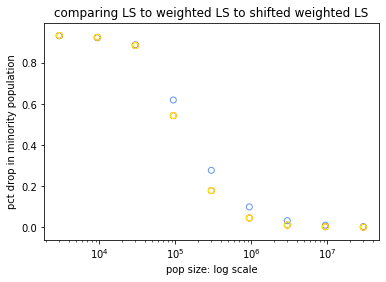

In [111]:
#this is identital to non-shifted weighted

x = compare_weighted_shifted['total_pop']
y_1 = compare_weighted_shifted['pct_change_std']
y_2 = compare_weighted_shifted['pct_change_weighted']
y_3 = compare_weighted_shifted['pct_change_shifted_weighted']

fig = plt.figure() 

ax = fig.add_subplot(111)
ax.scatter(x, y_1, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, y_2, facecolors='none', edgecolors = 'red')
ax.scatter(x, y_3, facecolors='none', edgecolors = 'yellow')

plt.xscale('log')
plt.xlabel('pop size: log scale')
plt.ylabel('pct drop in minority population')
plt.title("comparing LS to weighted LS to shifted weighted LS")

plt.show()

## compare grouped

In [98]:
grouped_path = '/ihme/scratch/users/beatrixh/2020-02-24/group'

grouped_dt = pd.DataFrame()
for path in weighted_dirs:
    new = summarize_dir(path)
    grouped_dt = pd.concat([grouped_dt, new], axis = 1, ignore_index=True)
print(grouped_dt.T)

              0              1              2         3           4       5   \
0    2438.414585    2449.876124    1123.468586  0.542943  9990.00999  0.1998   
1  798436.925075  798446.857143  797972.402752  0.000593  9990.00999  0.1998   
2     722.678322     724.028971      83.290169  0.884349  9990.00999  0.1998   
3      37.235764      37.987013       2.370797  0.932939  9990.00999  0.1998   
4   25151.210789   25142.654346   24030.444526  0.045126  9990.00999  0.1998   
5    7890.475524    7874.085914    6498.866427  0.178137  9990.00999  0.1998   
6   79748.700300   79730.367632   78899.852392  0.010775  9990.00999  0.1998   
7     191.737263     192.488511      14.188028  0.924062  9990.00999  0.1998   
8  252406.841159  252411.167832  251792.126827  0.002469  9990.00999  0.1998   

        6             7        8         9          10  
0  9.99001  9.477356e+04  0.04995  0.999001  449.55045  
1  9.99001  2.997003e+07  0.04995  0.999001  449.55045  
2  9.99001  2.997003e+04  0.

In [99]:
names = ['precise','dp','non_neg_grouped','pct_change_grouped',
        'number_counties','alpha','beta','total_pop',
        'prop_minority','segregation_factor','seed']
names_dict = {i : names[i] for i in range(0,len(names))}
data_grouped = grouped_dt.T.rename(columns=names_dict)
data_grouped.sort_values(by='total_pop')

,precise,dp,non_neg_grouped,pct_change_grouped,number_counties,alpha,beta,total_pop,prop_minority,segregation_factor,seed
3,37.235764,37.987013,2.370797,0.932939,9990.00999,0.1998,9.99001,2.997003e+03,0.04995,0.999001,449.55045
7,191.737263,192.488511,14.188028,0.924062,9990.00999,0.1998,9.99001,9.477356e+03,0.04995,0.999001,449.55045
2,722.678322,724.028971,83.290169,0.884349,9990.00999,0.1998,9.99001,2.997003e+04,0.04995,0.999001,449.55045
0,2438.414585,2449.876124,1123.468586,0.542943,9990.00999,0.1998,9.99001,9.477356e+04,0.04995,0.999001,449.55045
5,7890.475524,7874.085914,6498.866427,0.178137,9990.00999,0.1998,9.99001,2.997003e+05,0.04995,0.999001,449.55045
4,25151.210789,25142.654346,24030.444526,0.045126,9990.00999,0.1998,9.99001,9.477356e+05,0.04995,0.999001,449.55045
6,79748.700300,79730.367632,78899.852392,0.010775,9990.00999,0.1998,9.99001,2.997003e+06,0.04995,0.999001,449.55045
8,252406.841159,252411.167832,251792.126827,0.002469,9990.00999,0.1998,9.99001,9.477356e+06,0.04995,0.999001,449.55045
1,798436.925075,798446.857143,797972.402752,0.000593,9990.00999,0.1998,9.99001,2.997003e+07,0.04995,0.999001,449.55045


In [103]:
compare_grouped = compare_weighted_shifted.merge(data_grouped, how = 'inner',
                                                on=['alpha','beta','dp','number_counties','precise',
                                                    'prop_minority','seed','total_pop'],
                                                suffixes=('_copy','_grouped'))
compare_grouped.columns

Index(['precise', 'dp', 'non_neg_std', 'pct_change_std', 'number_counties',
       'alpha', 'beta', 'total_pop', 'prop_minority', 'segregation_factor_std',
       'seed', 'non_neg_weighted', 'pct_change_weighted',
       'segregation_factor_weighted', 'non_neg_shifted_weighted',
       'pct_change_shifted_weighted', 'segregation_factor_copy',
       'non_neg_grouped', 'pct_change_grouped', 'segregation_factor_grouped'],
      dtype='object')

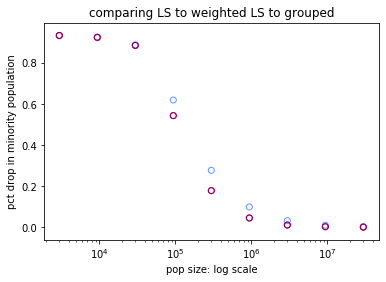

In [110]:
#this one also identical to weighted??

x = compare_grouped['total_pop']
y_1 = compare_grouped['pct_change_std']
y_2 = compare_grouped['pct_change_weighted']
y_3 = compare_grouped['pct_change_grouped']

fig = plt.figure() 

ax = fig.add_subplot(111)
ax.scatter(x, y_1, facecolors='none', edgecolors = 'cornflowerblue')
ax.scatter(x, y_2, facecolors='none', edgecolors = 'red')
ax.scatter(x, y_3, facecolors='none', edgecolors = 'purple')

plt.xscale('log')
plt.xlabel('pop size: log scale')
plt.ylabel('pct drop in minority population')
plt.title("comparing LS to weighted LS to grouped")

plt.show()